In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.2 MB/s eta 0:00:00


In [ ]:
pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 2.0 MB/s eta 0:00:00


In [ ]:

import torch
import numpy as np
import os
import datetime
from copy import deepcopy

from transformers import (RobertaTokenizer,
                          RobertaForSequenceClassification,
                          Trainer,
                          TrainingArguments,
                          TrainerCallback)
from datasets import (load_dataset,
                      load_metric,
                      load_dataset_builder,
                      ClassLabel,
                      Value,
                      Features)

In [ ]:

import transformers
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW, get_linear_schedule_with_warmup,RobertaTokenizer,RobertaForSequenceClassification

# Load the model and tokenizer
model_name = "roberta-large"
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=3)
tokenizer = RobertaTokenizer.from_pretrained(model_name, do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
BATCH_SIZE = 32


DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [ ]:
from sklearn.model_selection import train_test_split
from datasets import load_dataset

# Load the dataset
train_data = load_dataset('multi_nli', split='train')
val_data_matched = load_dataset('multi_nli', split='validation_matched')
val_data_mismatched = load_dataset('multi_nli', split='validation_mismatched')

total_rows = len(train_data)
desired_rows = int(0.2 * total_rows)
train_data = train_data.shuffle(seed=42).select(list(range(1000)))


total_rows = len(val_data_matched)
desired_rows = int(0.2 * total_rows)
val_data_matched = val_data_matched.shuffle(seed=42).select(list(range(1000)))

total_rows = len(val_data_mismatched)
desired_rows = int(0.2 * total_rows)
val_data_mismatched = val_data_mismatched.shuffle(seed=42).select(list(range(1000)))

def tokenize_function(examples):
    return tokenizer(examples['premise'], examples['hypothesis'], padding="max_length", max_length=128, truncation=True)

train_data = train_data.map(tokenize_function, batched=True)
val_data_matched = val_data_matched.map(tokenize_function, batched=True)
val_data_mismatched = val_data_mismatched.map(tokenize_function, batched=True)

# Set the format for torch tensors
train_data.set_format('torch', columns=["input_ids", "attention_mask", "label"])
val_data_matched.set_format('torch', columns=["input_ids", "attention_mask", "label"])
val_data_mismatched.set_format('torch', columns=["input_ids", "attention_mask", "label"])


In [ ]:
metric_name = "accuracy"

args = TrainingArguments(
    output_dir="./roberta_finetuned",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    resume_from_checkpoint=True,
)


def compute_metrics(eval_pred):
    metric = load_metric('glue', "mnli")

    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
class CustomCallback(TrainerCallback):

    def __init__(self, trainer) -> None:
        super().__init__()
        self._trainer = trainer

    def on_epoch_end(self, args, state, control, **kwargs):
        if control.should_evaluate:
            control_copy = deepcopy(control)
            self._trainer.evaluate(eval_dataset=self._trainer.train_dataset, metric_key_prefix="train")
            return control_copy


trainer = Trainer(
    model,
    args,
    train_dataset=train_data, #tokenized_train_data,
    eval_dataset=val_data_matched,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

#trainer.add_callback(CustomCallback(trainer))


trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.099650,0.328000
2,No log,0.966446,0.534000
3,No log,0.713118,0.748000
4,No log,0.607052,0.777000
5,No log,0.805385,0.765000
6,No log,1.065737,0.785000
7,No log,1.255813,0.783000
8,No log,1.239102,0.791000
9,No log,1.244685,0.797000
10,No log,1.273732,0.793000


<ipython-input-5-94a9e1b417a4>:19: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('glue', "mnli")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for glue contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/glue/glue.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for glue contains custom code which must be executed to correctly load the metric. You can inspect the repository con

TrainOutput(global_step=320, training_loss=0.355634069442749, metrics={'train_runtime': 1337.2147, 'train_samples_per_second': 7.478, 'train_steps_per_second': 0.239, 'total_flos': 2329836280320000.0, 'train_loss': 0.355634069442749, 'epoch': 10.0})

In [ ]:
# Evaluate on the test set
results = trainer.evaluate(val_data_mismatched)
print(results)

{'eval_loss': 1.1147422790527344, 'eval_accuracy': 0.81, 'eval_runtime': 22.3042, 'eval_samples_per_second': 44.835, 'eval_steps_per_second': 1.435, 'epoch': 10.0}


/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for glue contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/glue/glue.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
test_dataloader = DataLoader(val_data_mismatched, shuffle=False, batch_size=32)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for glue contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/glue/glue.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
100%|██████████| 32/32 [00:22<00:00,  1.41it/s]

epoch 10 - Test: {'accuracy': 0.81}


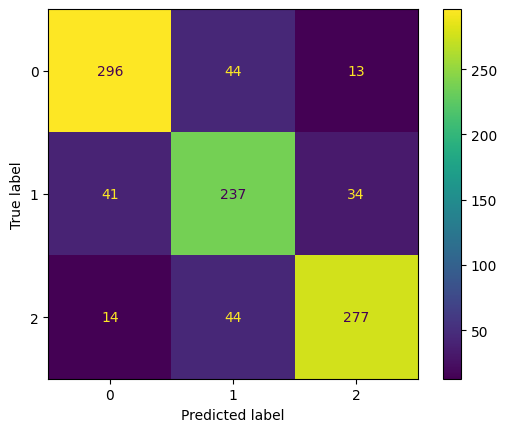

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
device = "cuda"
model.eval()
metric = load_metric('glue', "mnli")

all_predictions = []
all_references = []
for step, batch in enumerate(tqdm(test_dataloader)):
    with torch.no_grad():
        input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    predictions = outputs.logits.argmax(dim=-1)
    all_predictions.extend(predictions.cpu().numpy())
    all_references.extend(batch["label"].cpu().numpy())
    metric.add_batch(
        predictions=predictions,
        references=batch["label"],
    )
epoch=10
test_metric = metric.compute()
print(f"epoch {epoch} - Test:", test_metric)

# Calculate and show confusion matrix for the test set
cm = confusion_matrix(all_references, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2])
disp.plot()

# Lora

In [ ]:
!pip install peft

In [ ]:
import argparse
import os

import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
from peft import (
    get_peft_config,
    get_peft_model,
    get_peft_model_state_dict,
    set_peft_model_state_dict,
    LoraConfig,
    PeftType,
    PrefixTuningConfig,
    PromptEncoderConfig,
)

from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup, set_seed
from tqdm import tqdm

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
from peft import LoraConfig, TaskType

batch_size = 32
model_name_or_path = "roberta-large"
task = "mrpc"
peft_type = PeftType.LORA
device = "cuda"
num_epochs = 10
peft_config = LoraConfig(task_type="SEQ_CLS", r=8, lora_alpha=16, lora_dropout=0.1)
lr = 3e-4

pretrained_model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path, return_dict=True,num_labels=3)

print_trainable_parameters(pretrained_model)

model = get_peft_model(pretrained_model, peft_config)

print_trainable_parameters(model)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 355362819 || all params: 355362819 || trainable%: 100.0
trainable params: 1839107 || all params: 357201926 || trainable%: 0.5148648050682683


In [ ]:
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=32)
eval_dataloader = DataLoader(val_data_matched, shuffle=False, batch_size=32)
test_dataloader = DataLoader(val_data_mismatched, shuffle=False, batch_size=32)

In [ ]:
optimizer = AdamW(params=model.parameters(), lr=lr)

# Instantiate scheduler
num_epochs=10
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0.06 * (len(train_dataloader) * num_epochs),
    num_training_steps=(len(train_dataloader) * num_epochs),
)
metric = load_metric('glue', "mnli")

model.to(device)
for epoch in range(num_epochs):
    model.train()
    for step, batch in enumerate(tqdm(train_dataloader)):
        input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    model.eval()
    for step, batch in enumerate(tqdm(eval_dataloader)):
        with torch.no_grad():
          input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['label'].to(device)
          outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        predictions = outputs.logits.argmax(dim=-1)
        predictions, references = predictions, batch["label"]
        metric.add_batch(
            predictions=predictions,
            references=references,
        )

    eval_metric = metric.compute()
    print(f"epoch {epoch}:", eval_metric)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for glue contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/glue/glue.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
100%|██████████| 32/32 [00:21<00:00,  1.49it/s]


epoch 0: {'accuracy': 0.344}


100%|██████████| 32/32 [00:21<00:00,  1.50it/s]


epoch 1: {'accuracy': 0.33}


100%|██████████| 32/32 [00:21<00:00,  1.50it/s]


epoch 2: {'accuracy': 0.42}


100%|██████████| 32/32 [00:21<00:00,  1.51it/s]


epoch 3: {'accuracy': 0.538}


100%|██████████| 32/32 [00:21<00:00,  1.50it/s]


epoch 4: {'accuracy': 0.737}


100%|██████████| 32/32 [00:21<00:00,  1.51it/s]


epoch 5: {'accuracy': 0.735}


100%|██████████| 32/32 [00:21<00:00,  1.51it/s]


epoch 6: {'accuracy': 0.725}


100%|██████████| 32/32 [00:21<00:00,  1.51it/s]


epoch 7: {'accuracy': 0.747}


100%|██████████| 32/32 [00:21<00:00,  1.51it/s]


epoch 8: {'accuracy': 0.76}


100%|██████████| 32/32 [00:21<00:00,  1.50it/s]


epoch 9: {'accuracy': 0.767}


100%|██████████| 32/32 [00:21<00:00,  1.51it/s]


epoch 9 - Test: {'accuracy': 0.787}


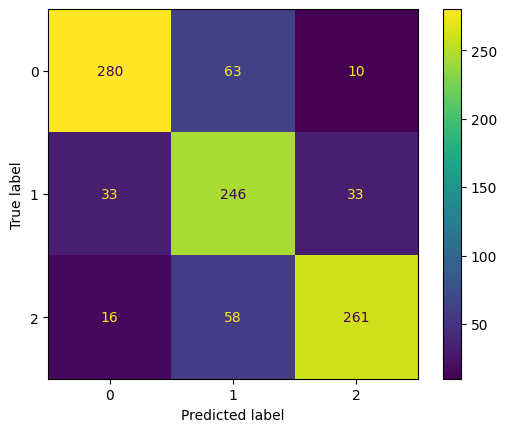

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()
all_predictions = []
all_references = []
for step, batch in enumerate(tqdm(test_dataloader)):
    with torch.no_grad():
        input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    predictions = outputs.logits.argmax(dim=-1)
    all_predictions.extend(predictions.cpu().numpy())
    all_references.extend(batch["label"].cpu().numpy())
    metric.add_batch(
        predictions=predictions,
        references=batch["label"],
    )

test_metric = metric.compute()
print(f"epoch {epoch} - Test:", test_metric)

# Calculate and show confusion matrix for the test set
cm = confusion_matrix(all_references, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2])
disp.plot()